### Topic A: Model Selection(Complexity Control)

In [1]:
import numpy as np
import pandas as pd

#read the file of haberman.data 
df = pd.read_csv('haberman.data', header=None,
names=["age_at_operation", "year_of_operation", "no_of_pos_aux_nodes", "survival_status"])

#displaying the data 
df

,age_at_operation,year_of_operation,no_of_pos_aux_nodes,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
...,...,...,...,...
301,75,62,1,1
302,76,67,0,1
303,77,65,3,1
304,78,65,1,2


In [2]:
#droping column 
df = df.drop("year_of_operation", axis=1)
df

,age_at_operation,no_of_pos_aux_nodes,survival_status
0,30,1,1
1,30,3,1
2,30,0,1
3,31,2,1
4,31,4,1
...,...,...,...
301,75,1,1
302,76,0,1
303,77,3,1
304,78,1,2


#### Preprocessing: Normalization 

In [3]:
# min max sacler function to normalize the data i.e. to bring the data points in the range of 0 to 1.
def min_max_scaler(df: pd.DataFrame):
    for col, min, max in zip(df.columns, df.min(), df.max()):
        df[col] = df[col].map(lambda x: (x - min)/(max - min))
    return df

scaled_df = min_max_scaler(df)
scaled_df

,age_at_operation,no_of_pos_aux_nodes,survival_status
0,0.000000,0.019231,0.0
1,0.000000,0.057692,0.0
2,0.000000,0.000000,0.0
3,0.018868,0.038462,0.0
4,0.018868,0.076923,0.0
...,...,...,...
301,0.849057,0.019231,0.0
302,0.867925,0.000000,0.0
303,0.886792,0.057692,0.0
304,0.905660,0.019231,1.0


#### a.1 Method implementation

In [4]:
#KNN implementation: euclidean distance is imported
from scipy.spatial.distance import euclidean
import random

#all datapoints are taken. K and new datapoint is entered by the user
def KNN(dataframe: pd.DataFrame, K: int, new_datapoint: pd.Series) -> float:
    KNN_indices = dataframe.reset_index(drop=True).drop("survival_status", axis=1).apply(lambda row: euclidean(row, new_datapoint), axis=1).sort_values()[:K].index

    #frequency to store the frequency to store the vale of datapoints havins survival status = 0 in freq[0] and survival status = 0 in freq[1]    
    freq = [0, 0]
    for i in KNN_indices:
        if dataframe.iloc[i]["survival_status"] == 0.0:
            freq[0] += 1
        else:
            freq[1] += 1

    #if freq of both is equal     
    if freq[0] == freq[1]:
        return random.choice(0.0, 1.0)
    #if freq[0] > freq[1] then we will return 0 (class 0) otherwise we will return 1(class 1)
    if freq[0] > freq[1]:
        return 0.0
    else:
        return 1.0

#### a.2 Model Selection

##### LOO validation

In [5]:
#leave one out cross validation
def LOO(dataframe):
    #droping the column of survival status
    unlabelled_df = dataframe.drop("survival_status", axis=1)
    #Empty list to store the error
    error = []

    #Loop for k = 1,3,...99
    for K in range(1, min(100, dataframe.shape[0]), 2):
        #creating a list of actual values of survival status
        actual_values = [i for i in dataframe["survival_status"]]
        
        #list for predicted values
        predicted_values = [None for _ in actual_values]
        
        # Loop for each row 
        for i in range(dataframe.shape[0]):
            #In leave one out, one row is leaved so leaving ith row and including all other rows
            local_df = dataframe.drop(i, axis=0)
            
            #Using KNN function predicted the value for ith row
            predicted_values[i] = KNN(local_df, K, unlabelled_df.iloc[i])
        
        #calculated error for predicted value and actual value using mean square error
        MSE = sum([abs(a - p) for a, p in zip(actual_values, predicted_values)])/local_df.shape[0]
        
        #Now appending the k value and corresponding mse
        error.append([K, MSE])

    # Return a dataframe of the error values for each K value.
    return pd.DataFrame(error, columns=["K", "error"])

#error value   
cross_val_err = LOO(scaled_df)

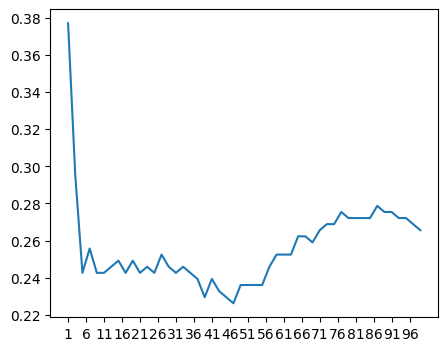

In [15]:
#ploting the graph 
import matplotlib.pyplot as plt

# set figure size
plt.figure(figsize = (5,4))

# set ticks for x-axis
plt.xticks(list(range(1, 100, 5)))

# display the plot
plt.plot(cross_val_err["K"], cross_val_err["error"])


##### Finding optimal K value

In [7]:
# finding the row with the minimum error
optimal_K_row = cross_val_err.iloc[cross_val_err["error"].idxmin()]

# finding the optimal value of K from the row
optimal_K = int(optimal_K_row["K"])

# finding the optimal error value from the row
optimal_err = optimal_K_row["error"]

# Printing the optimal value of K and the corresponding error value
print("Optimal value of K:", optimal_K)
print("Error with the optimal value :", optimal_err)


Optimal value of K: 47
Error with the optimal value : 0.2262295081967213


#### Decision Boundary
Classifying points spread all over the 2d area to visualize the decision boundary

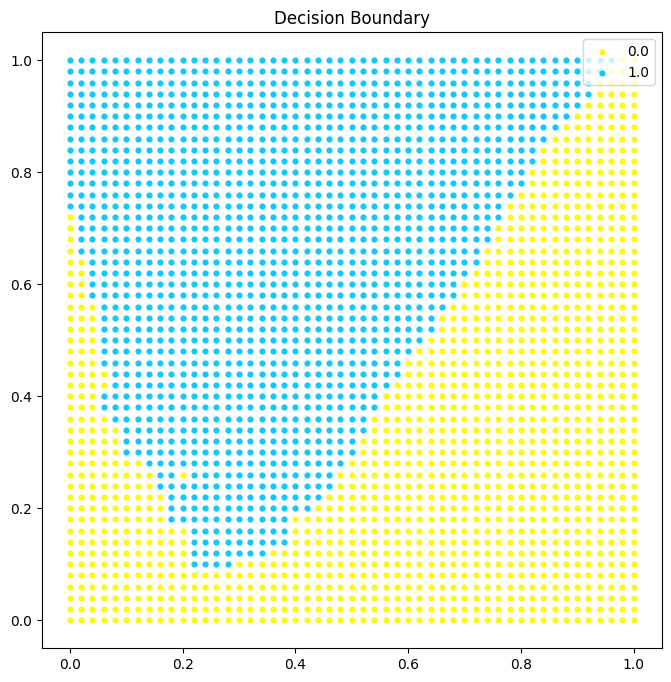

In [8]:
#Empty list to store the points
points = []

# dimension of grid
dim = 50

# Iterating over each point in the grid
for i in range(dim+1):
    for j in range(dim+1):
        # Usint the knn func predicting the class
        points.append([i/dim, j/dim, KNN(scaled_df, optimal_K, [i/30, j/30])])

# Convert the list of points to a Pandas DataFrame
points = pd.DataFrame(points, columns=['x', 'y', 'class'])

# Grouping the points by their class label
grouped_points = [i for _, i in points.groupby("class", sort=False)]

# Set the size of the plot
plt.rcParams["figure.figsize"] = (8, 8)

# Plot each group of points with a different color and marker size
for pts, color in zip([i for i in grouped_points], ["#FCF813", "#13C7FC"]):
    # Get the class label of the points
    cls = pts.iloc[0]["class"]
    # Plot the points with the specified color and marker size
    plt.scatter(pts["x"], pts["y"], c=color, s=12.0, label=cls)
    
# Set the title of the plot and add a legend
plt.title("Decision Boundary")
plt.legend(loc='upper right')

# Display the plot
plt.show()


#### a.3 Prediction accuracy of a learning method

Creating the folds

In [9]:
#sorting according to age at operation
sorted_df = scaled_df.sort_values("age_at_operation")

folds = [pd.DataFrame(sorted_df.iloc[i::5]).reset_index(drop=True) for i in range(5)]

Finding the optimal k for each fold using Leave One Out Validation

In [10]:
# Computing leave one out error for each fold
cross_val_errs = [LOO(i) for i in folds]

# Identify the row with the optimal error for each fold
optimal_K_rows = [i.iloc[i["error"].idxmin()] for i in cross_val_errs]

# Extract the optimal K value for each fold
optimal_Ks = [int(i["K"]) for i in optimal_K_rows]

# Extract the LOO error for each fold using the optimal K value
loo_val_errs = [i["error"] for i in optimal_K_rows]


Calculating test error

In [11]:
# This function is used to calculate the mean squared error (MSE) for the test set
def test(train: pd.DataFrame, test: list, K: int):
    # Concatenate all the test folds into a single dataframe
    test = pd.concat(test, ignore_index=True)
    # Drop the "survival_status" column from the test set
    test_df = test.drop("survival_status", axis=1)
    # The training set is already passed as an argument
    train_df = train
    # Create a list of actual values for the test set
    actual_values = [i for i in test["survival_status"]]
    # Create a list of predicted values for the test set using KNN algorithm
    predicted_values = [KNN(train_df, K, i) for _, i in test_df.iterrows()]
    # Calculate the mean squared error (MSE) between actual and predicted values
    MSE = sum([abs(a - p) for a, p in zip(actual_values, predicted_values)])/test_df.shape[0]
    return MSE

# This list comprehension is used to calculate the estimated test errors for each fold
est_test_errs = [test(folds[i], [folds[j] for j in range(5) if j != i], optimal_Ks[i]) for i in range(5)]


In [12]:
pd.DataFrame({
    "Fold number": [1, 2, 3, 4, 5],
    "Optimal value of K": optimal_Ks,
    "LOO validation error": loo_val_errs,
    "Estimated test error": est_test_errs
})

,Fold number,Optimal value of K,LOO validation error,Estimated test error
0,1,11,0.245902,0.245902
1,2,11,0.300000,0.236735
2,3,5,0.150000,0.261224
3,4,1,0.283333,0.326531
4,5,9,0.233333,0.273469


In [13]:
avg_test_err = sum(est_test_errs)/5
avg_loo_val_err = sum(loo_val_errs)/5
print("Average LOO cross validation error:", avg_loo_val_err)
print("True test error:", avg_test_err)
print("Optimal K (from a.2 ) error:", optimal_err)

Average LOO cross validation error: 0.2425136612021858
True test error: 0.2687721646035463
Optimal K (from a.2 ) error: 0.2262295081967213


In [14]:
print(f'The exact/true test error is {100*(avg_test_err - optimal_err)/optimal_err:.2f}% more than that of Optimal K error (from a.2 )')

The exact/true test error is 18.81% more than that of Optimal K error (from a.2 )


<br>
End of Topic-A